# Deep Bidirectional Long Short Term Memory

In [1]:
! nvidia-smi

Sat May 20 00:01:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8     3W /  N/A |      1MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [2]:
import os

import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
import sklearn.preprocessing

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers

In [3]:
# Seed to reproduce results
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
train_df = pd.read_json('data/stock_train.json')
test_df = pd.read_json('data/stock_test.json')

In [5]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [6]:
test_df

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [7]:
# Label One-Hot-Encoding
label_encoded = sklearn.preprocessing.OneHotEncoder(sparse=False).fit_transform(pd.DataFrame([*list(train_df.label_id), *list(test_df.label_id)]))

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text, label_encoded[:len(train_df)]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.text, label_encoded[len(train_df):]))

# Batches
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Encoder

In [9]:
# Encoder Vocab Size
VOCAB_SIZE = 10000

# Encoder
encoder = layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vocab
print(f"Vocab_size: {len(encoder.get_vocabulary())}")
encoder.get_vocabulary()[:10]

Vocab_size: 2279


['', '[UNK]', 'và', 'trong', 'tăng', 'với', 'cổ', 'của', 'có', 'đầu']

In [10]:
model = Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
        ),
    layers.Bidirectional(layers.LSTM(64, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "sigmoid")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         291712    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [13]:
# Compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(5 * 1e-3),
    metrics = 'acc'
)

# Train 
history_training = model.fit(
    train_dataset, 
    epochs = 50,
    validation_data = test_dataset
)

Epoch 1/50
12/12 [==============================] - 22s 692ms/step - loss: 0.0094 - acc: 0.9960 - val_loss: 1.9075 - val_acc: 0.5948
Epoch 2/50
12/12 [==============================] - 3s 214ms/step - loss: 0.0101 - acc: 0.9947 - val_loss: 1.8979 - val_acc: 0.6218
Epoch 3/50
12/12 [==============================] - 2s 206ms/step - loss: 0.0194 - acc: 0.9908 - val_loss: 1.6155 - val_acc: 0.6198
Epoch 4/50
12/12 [==============================] - 2s 195ms/step - loss: 0.0197 - acc: 0.9921 - val_loss: 1.5926 - val_acc: 0.6128
Epoch 5/50
12/12 [==============================] - 2s 212ms/step - loss: 0.0128 - acc: 0.9934 - val_loss: 1.4247 - val_acc: 0.6198
Epoch 6/50
12/12 [==============================] - 2s 206ms/step - loss: 0.0101 - acc: 0.9954 - val_loss: 1.5437 - val_acc: 0.5958
Epoch 7/50
12/12 [==============================] - 2s 202ms/step - loss: 0.0116 - acc: 0.9954 - val_loss: 1.5023 - val_acc: 0.6188
Epoch 8/50
12/12 [==============================] - 2s 207ms/step - loss: 0

(0.0, 1.0)

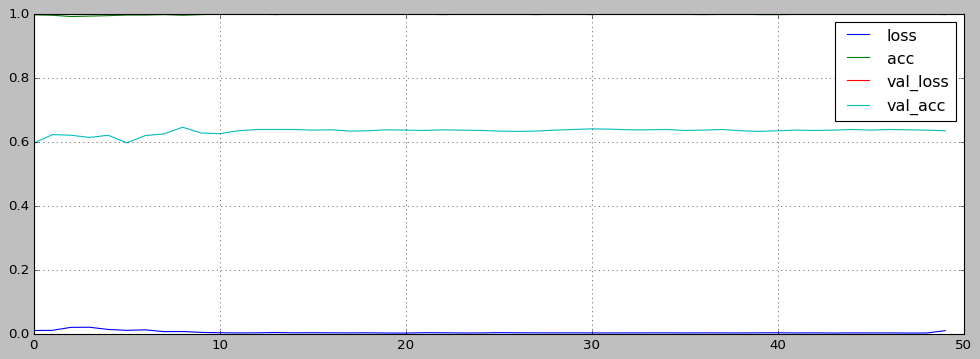

In [14]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
pd.DataFrame(history_training.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [15]:
# Evaluation
train_loss, train_acc = model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

# Prediction
preds = model.predict(test_df.text)
preds = tf.math.argmax(preds, -1)

# Report
report = sklearn.metrics.classification_report(test_df.label_id, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

32/32 [==============================] - 5s 17ms/step


,precision,recall,f1-score,support
0,0.654545,0.703911,0.678331,358.000000
1,0.686084,0.656347,0.670886,323.000000
2,0.555195,0.532710,0.543720,321.000000
accuracy,0.633733,0.633733,0.633733,0.633733
macro avg,0.631941,0.630989,0.630979,1002.000000
weighted avg,0.632884,0.633733,0.632807,1002.000000
